In [5]:
import cv2, matplotlib, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rect_util as ru

dr = 1
shifts = [(sx, sy) for sx in range(-dr, dr+1) for sy in range(-dr, dr+1)]
def pixel_match(img1, img2, r1, r2, center):
    x1, y1, x2, y2 = (r1[0], r1[1], r2[0], r2[1])
    w1, h1 = (r1[2] - r1[0], r1[3] - r1[1])
    w2, h2 = (r2[2] - r2[0], r2[3] - r2[1])
    if not abs(w1 - w2) <= dr or not abs(h1 - h2) <= dr:
        # FIXME
        return (False, [], [])
    w, h = (min(w1, w2), min(h1, h2))
    for dx, dy in shifts:
        imgr1 = img1[y1:y1+h, x1:x1+w]
        imgr2 = img2[y2+dy:y2+dy+h, x2+dx:x2+dx+w]
        result = np.allclose(imgr1, imgr2)
        if result:
            return (True, [], [])
    imgr1 = img1[y1:y1+h, x1:x1+w]
    imgr2 = img2[y2:y2+h, x2:x2+w]
    _, diff_img = cv2.threshold(cv2.cvtColor(cv2.absdiff(imgr1, imgr2), cv2.COLOR_RGB2GRAY),  10, 255, cv2.THRESH_BINARY)
    inner_rects = ru.marge_rects(ru.nonzero_rects(diff_img, 128, 128, True), 32)
    return (False, ru.shift_rects(inner_rects, (x1, y1)), ru.shift_rects(inner_rects, (x2, y2)))

def match_kps(kp1, des1, kp2, des2):
    bf = cv2.BFMatcher(2)
    matches = bf.knnMatch(des1, des2, k=2)
    ratio = 0.3
    good = []
    for m, n, in matches:
        if m.distance < ratio * n.distance:
            good.append([m])
    return good

def cluster_matches(kp1, des1, kp2, des2, matches, n):
    vectors = []
    num_k = min(int(len(matches) / 3), n)
    dxw, dyw, wy=(100, 1000, 100)
    for m in matches:
        x1, y1 = kp1[m.queryIdx].pt
        x2, y2 = kp2[m.trainIdx].pt
        vectors.append([x1, x2, wy*y1, wy*y2, dxw * round((x2 - x1)), dyw*(round(y2 - y1))])
    npmat=np.array(vectors)
    criteria =(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(np.float32(npmat), num_k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
    cgg = [[] for i in range(num_k)]
    i = 0
    for l in label:
        cgg[l[0]].append(matches[i])
        i = i + 1
    return cgg, ret, label, [[c[0], c[1], c[2] / wy, c[3] / wy, int(round(c[4] / dxw)), int(round(c[5] / dyw))] for c in center]

def cluster_kps(kplist, n = 10, wy = 10.0):
    matt = []
    for kp in kplist:
        matt.append([kp.pt[0], kp.pt[1] * wy])
    num_k = min(int(len(kplist) / 3), n)
    if (num_k < 2):
        return [] if len(kplist) < 2 else [kplist]
    npmat=np.array(matt)
    criteria =(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(np.float32(npmat), num_k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
    kps = [[] for i in range(num_k)]
    i = 0
    for l in label:
        kps[l[0]].append(kplist[i])
        i += 1
    return kps

%matplotlib inline

use_canny = True

def detect_diff(suffix):
    print('')
    print('Start to process: ', suffix)
    img1=cv2.imread('img/actual/' + suffix)
    img2=cv2.imread('img/expected/' + suffix)
    
    # Pre-processes for features detection
    if use_canny:
        img_in1 = cv2.Canny(img1, 10, 40)
        img_in2 = cv2.Canny(img2, 10, 40)
    else:
        img_in1 = img1
        img_in2 = img2
    
    # Detects Keypoints and Feature Descriptors
    akaze = cv2.AKAZE_create()
    kp1, des1 = akaze.detectAndCompute(img_in1, None)
    kp2, des2 = akaze.detectAndCompute(img_in2, None)
    print('The num of keypoints(img1):  ',  len(kp1))
    print('The num of keypoints(img2):  ',  len(kp2))
    
    # Mathches Features between img1 and img2
    matches = match_kps(kp1, des1, kp2, des2)
    
    # Filters matched pairs and clusters them
    filtered_matches = [m[0] for m in matches if abs(kp1[m[0].queryIdx].pt[0] - kp2[m[0].trainIdx].pt[0]) < 400]
    fmax = 400
    print('The num of matched: ', len(filtered_matches), len(matches))
    if len(filtered_matches) > fmax:
        print('Sumpling to ', fmax)
        filtered_matches = [filtered_matches[int(x * len(filtered_matches) / fmax)] for x in range(fmax)] 
      
    qd_vec = [(round(kpt2[0] - kpt1[0]), round(kpt2[1] - kpt1[1])) for kpt1, kpt2 in [(kp1[m.queryIdx].pt, kp2[m.trainIdx].pt) for m in filtered_matches]]
    n = int(2 * len(set(qd_vec))) 
    
    categorized_matches, ret, label, center = cluster_matches(kp1, des1, kp2, des2, filtered_matches, n)
    qdc = [(c[4], c[5]) for c in center]
    
    # Creates list of keypoints whitch is linked from the categorized matched pairs, or not
    categorized_kp1 = [[kp1[m.queryIdx] for m in matches] for matches in categorized_matches]
    categorized_kp2 = [[kp2[m.trainIdx] for m in matches] for matches in categorized_matches]
    not_categorized_kp1 = [kp for kp in kp1 if not kp in [kp1[m.queryIdx] for m in filtered_matches]]
    not_categorized_kp2 = [kp for kp in kp2 if not kp in [kp2[m.trainIdx] for m in filtered_matches]]
    
    # Extracts bounding rectangular for each matching keypoints
    matched_rects1 = ru.create_rects_from_points(categorized_kp1)
    matched_rects_closure1 = ru.marge_rects_if_same_center(matched_rects1, qdc, 60)
    matched_rects2 = ru.create_rects_from_points(categorized_kp2)
    matched_rects_closure2 = ru.marge_rects_if_same_center(matched_rects2, qdc, 60)
    
    cv = [x[1] for x in matched_rects_closure1]
    matched_rects1 = [x[0] for x in matched_rects_closure1]
    matched_rects2 = [x[0] for x in matched_rects_closure2]
    
    print('Quantized translation vectors: ', cv)
    
    # Tests images cropped by each boundary are same pixel-perfectly.
    # And picks up inner "Not matching" rects.
    pixel_match_result = [
        pixel_match(img1, img2, r1, r2, center) for r1, r2, center in [
            (matched_rects1[i], matched_rects2[i], cv[i]) for i in range(len(matched_rects1))
        ]
    ]
    inner_diff_rects1 = ru.marge_rects([
        item for sublist in [
            rects1 for x, rects1, rects2 in pixel_match_result if not x
        ] for item in sublist
    ])
    inner_diff_rects2 = ru.marge_rects([
        item for sublist in [
            rects2 for x, rects1, rects2 in pixel_match_result if not x
        ] for item in sublist
    ])
    
    # Clusters keypoints which are not in matching pairs. They are candidates of "Added(or Removed)" parts.
    # And extracts bounding rectangular for them.
    not_matched_rects1 = ru.create_rects_from_points(
        cluster_kps([kp for kp in not_categorized_kp1 if ru.in_boxes(kp, matched_rects1)])
    )
    not_matched_rects2 = ru.create_rects_from_points(
        cluster_kps([kp for kp in not_categorized_kp2 if ru.in_boxes(kp, matched_rects2)])
    )
    straying_rects1 = ru.marge_rects([r for r in not_matched_rects1 if ru.is_valid_rect(r)])
    straying_rects2 = ru.marge_rects([r for r in not_matched_rects2 if ru.is_valid_rect(r)])
    
    # Combine inner_diff and straying rects
    diff_rects1 = ru.marge_rects(inner_diff_rects1 + straying_rects1)
    diff_rects2 = ru.marge_rects(inner_diff_rects2 + straying_rects2)
    
    # Display images
    out_img1 = img1.copy()
    out_img2 = img2.copy()
    matching_img = cv2.drawMatchesKnn(img_in1, kp1, img_in2, kp2, [[m] for m in filtered_matches], None, flags=0)
    out_img1 = ru.render_rects(out_img1, diff_rects1, (100, 100, 200), 3)
    out_img1 = ru.render_rects(out_img1, matched_rects1, (100, 200, 100), 1, 0)
    out_img2 = ru.render_rects(out_img2, diff_rects2, (100, 100, 200), 3)
    out_img2 = ru.render_rects(out_img2, matched_rects2, (100, 200, 100), 1, 0)
    out_img = cv2.drawMatches(out_img1, [], out_img2, [], [], None, flags=0 )
    plt.figure(figsize=(24, 18))
    plt.imshow(cv2.cvtColor(cv2.vconcat([matching_img, out_img]), cv2.COLOR_BGR2RGB))
    cv2.imwrite('img/diff/' + suffix.replace('.png', '') + '_x.png', out_img)
    
    print('End to process: ', suffix)

In [6]:
#detect_diff('ut/cmp/should fetch similar sites.png')


Start to process:  tweetdeck.png
The num of keypoints(img1):   40008
The num of keypoints(img2):   39470
The num of matched:  33137 33171
Sumpling to  400
Quantized translation vectors:  [(0, -670), (0, 0)]
End to process:  tweetdeck.png

Start to process:  ut/cmp/should fetch similar sites.png
The num of keypoints(img1):   4863
The num of keypoints(img2):   4418
The num of matched:  3853 3861
Sumpling to  400
Quantized translation vectors:  [(0, 0), (0, 174), (0, -63)]
End to process:  ut/cmp/should fetch similar sites.png

Start to process:  ut/cmp/should debounce to fetch similar sites.png
The num of keypoints(img1):   970
The num of keypoints(img2):   527
The num of matched:  488 496
Sumpling to  400
Quantized translation vectors:  [(0, 0), (0, -63), (0, 174), (0, -63), (0, -63)]
End to process:  ut/cmp/should debounce to fetch similar sites.png

Start to process:  ut/cmp/should render similar site without invalid sites.png
The num of keypoints(img1):   1669
The num of keypoints(i

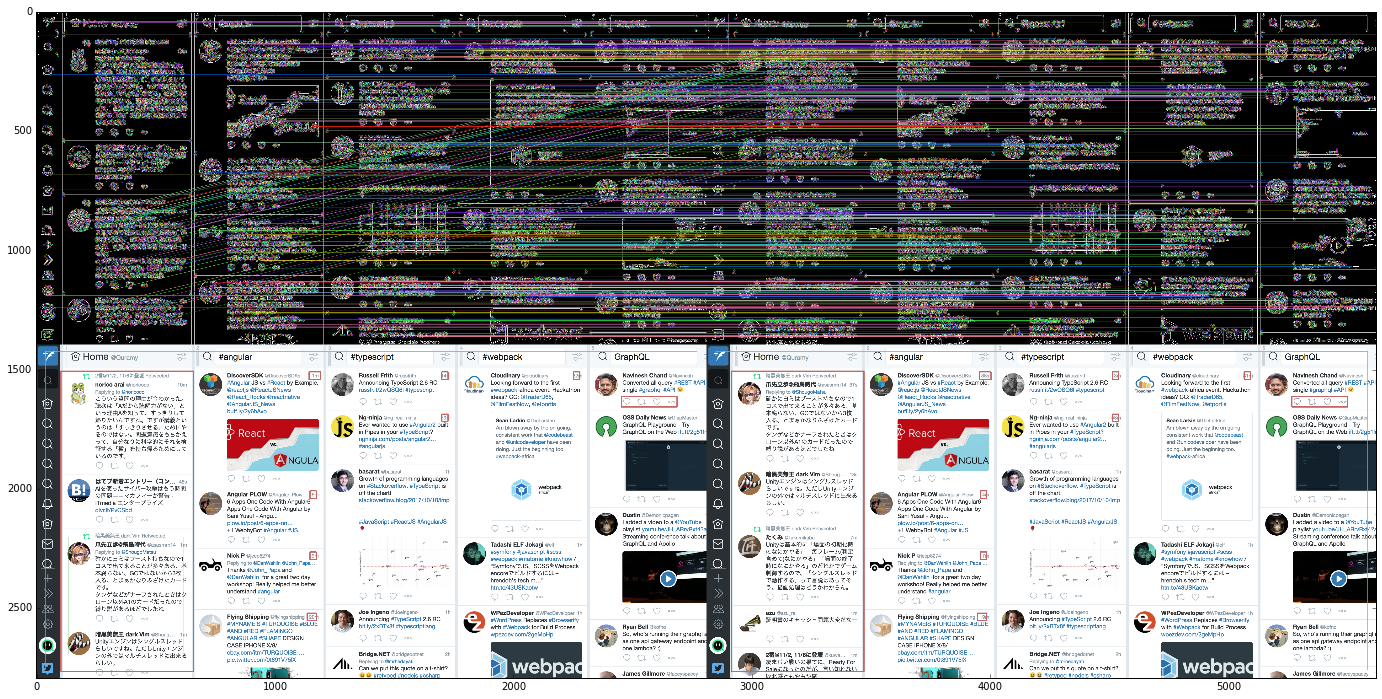

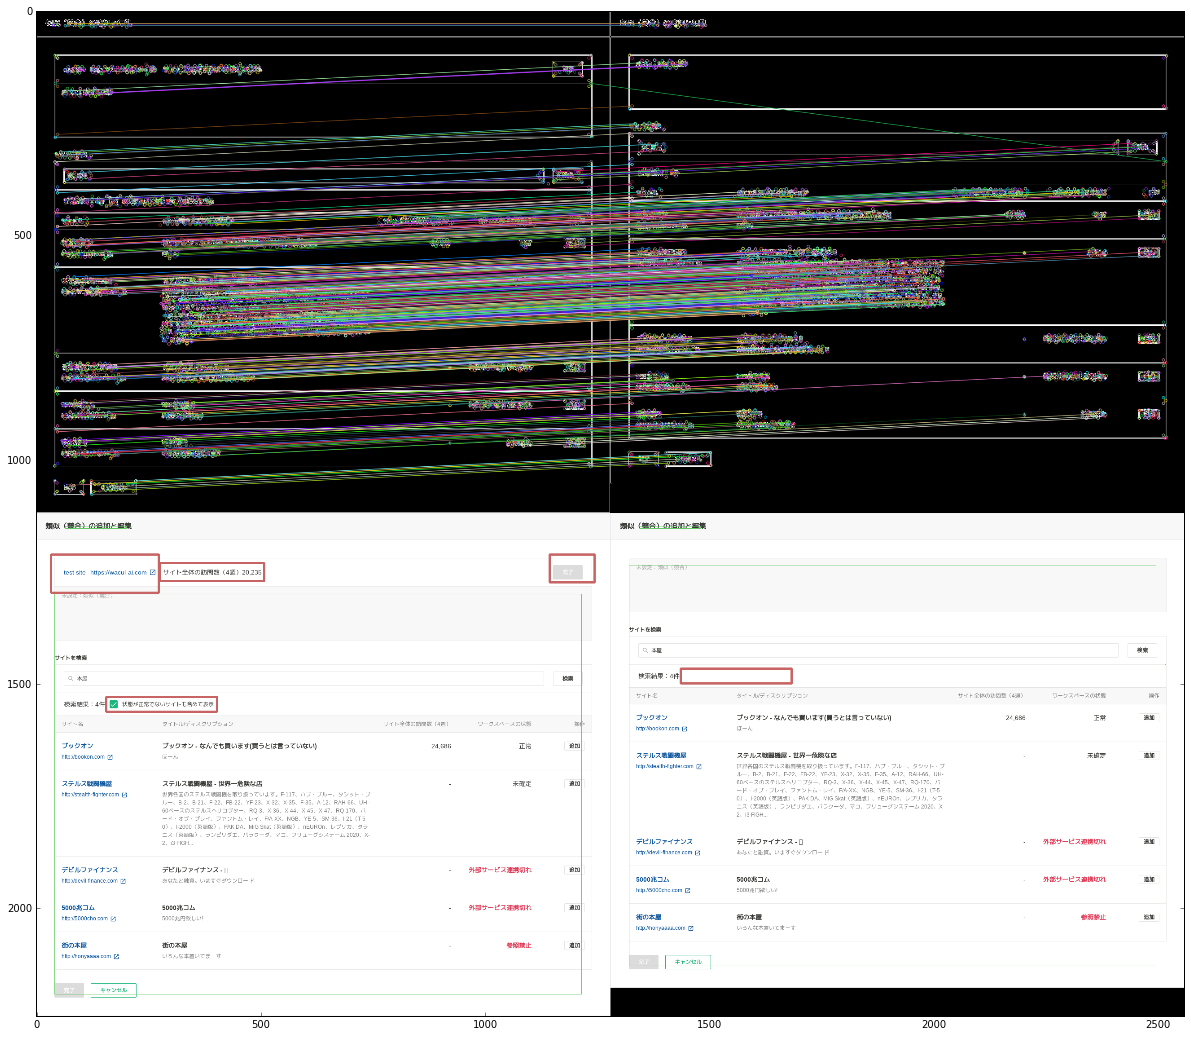

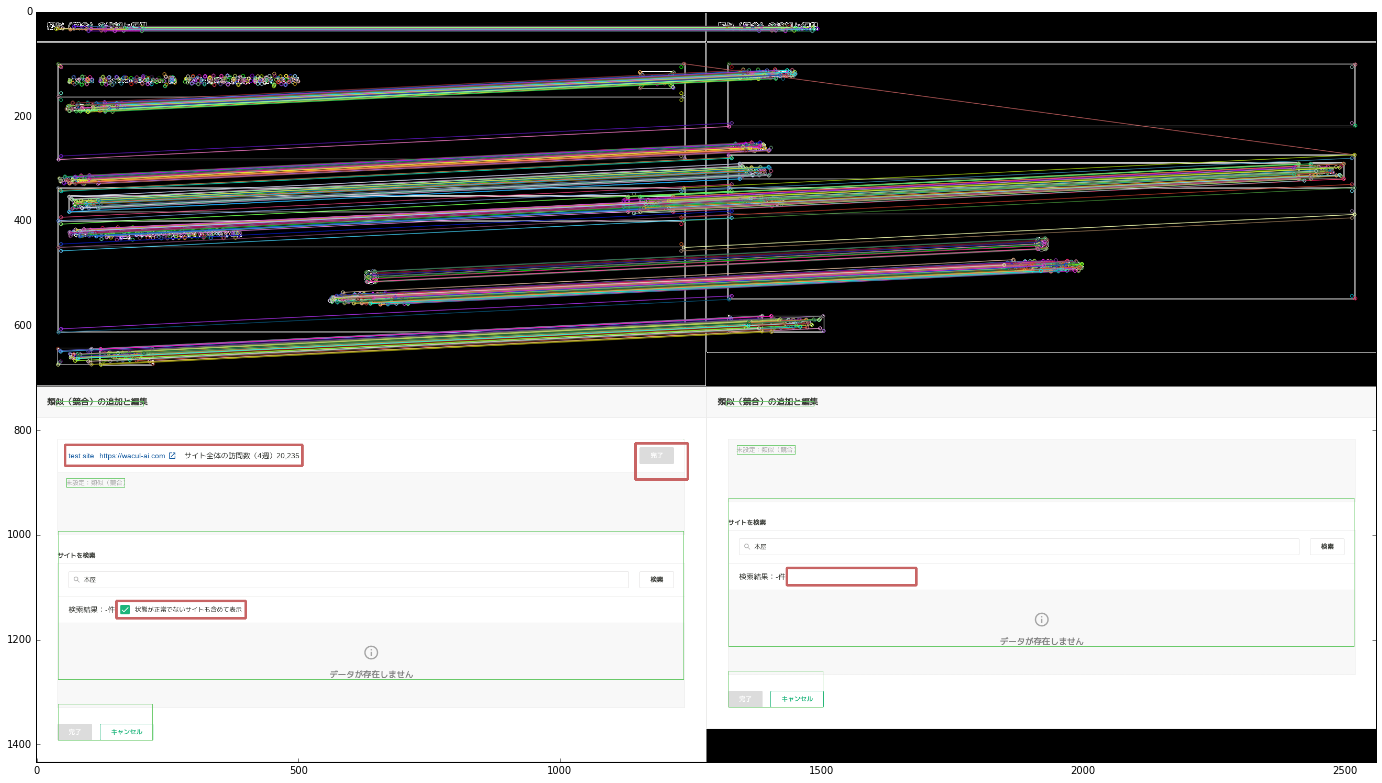

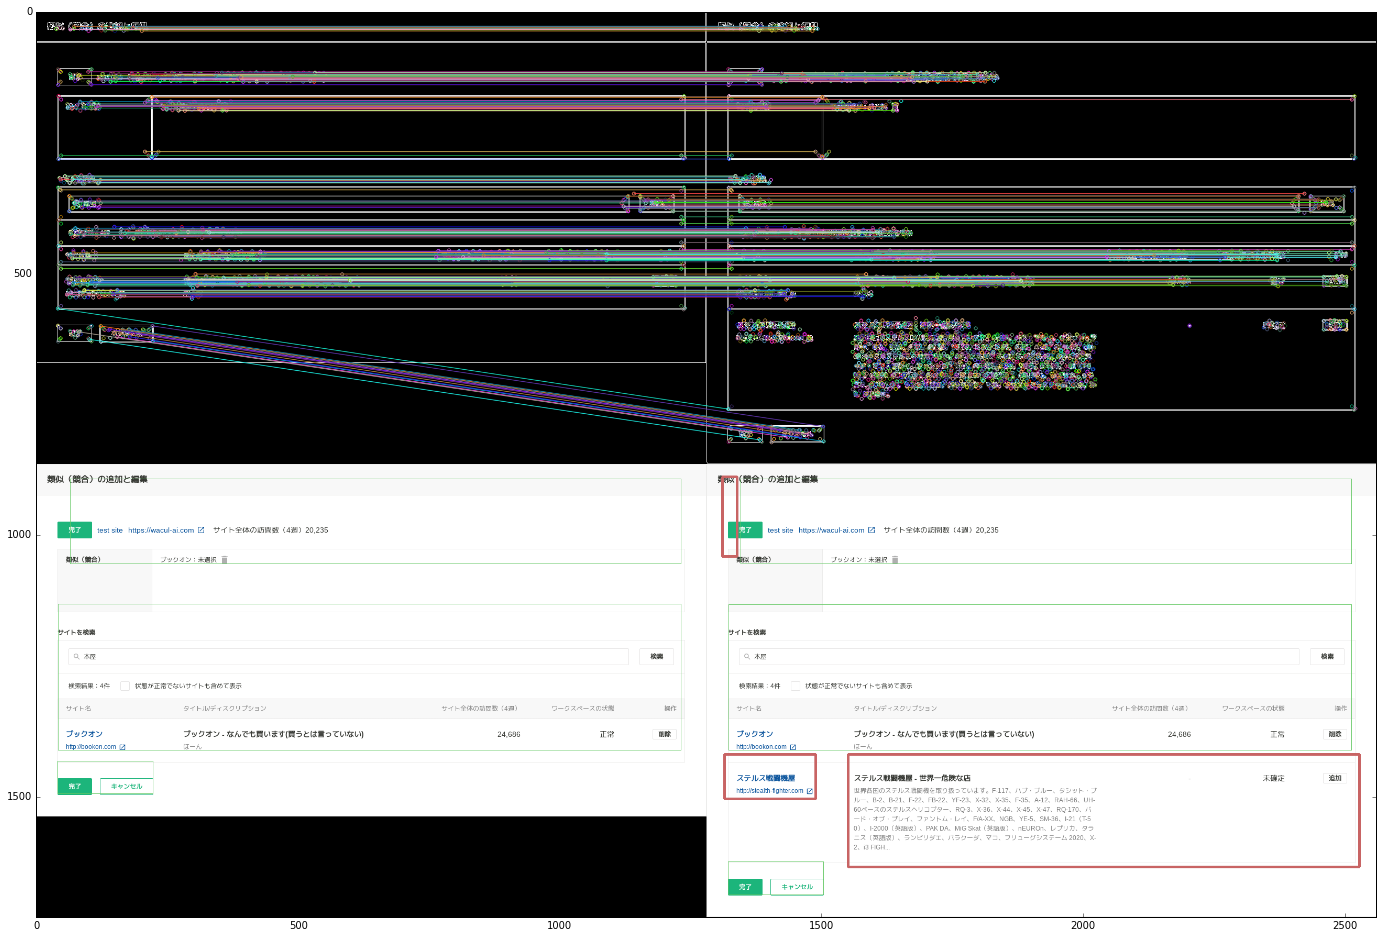

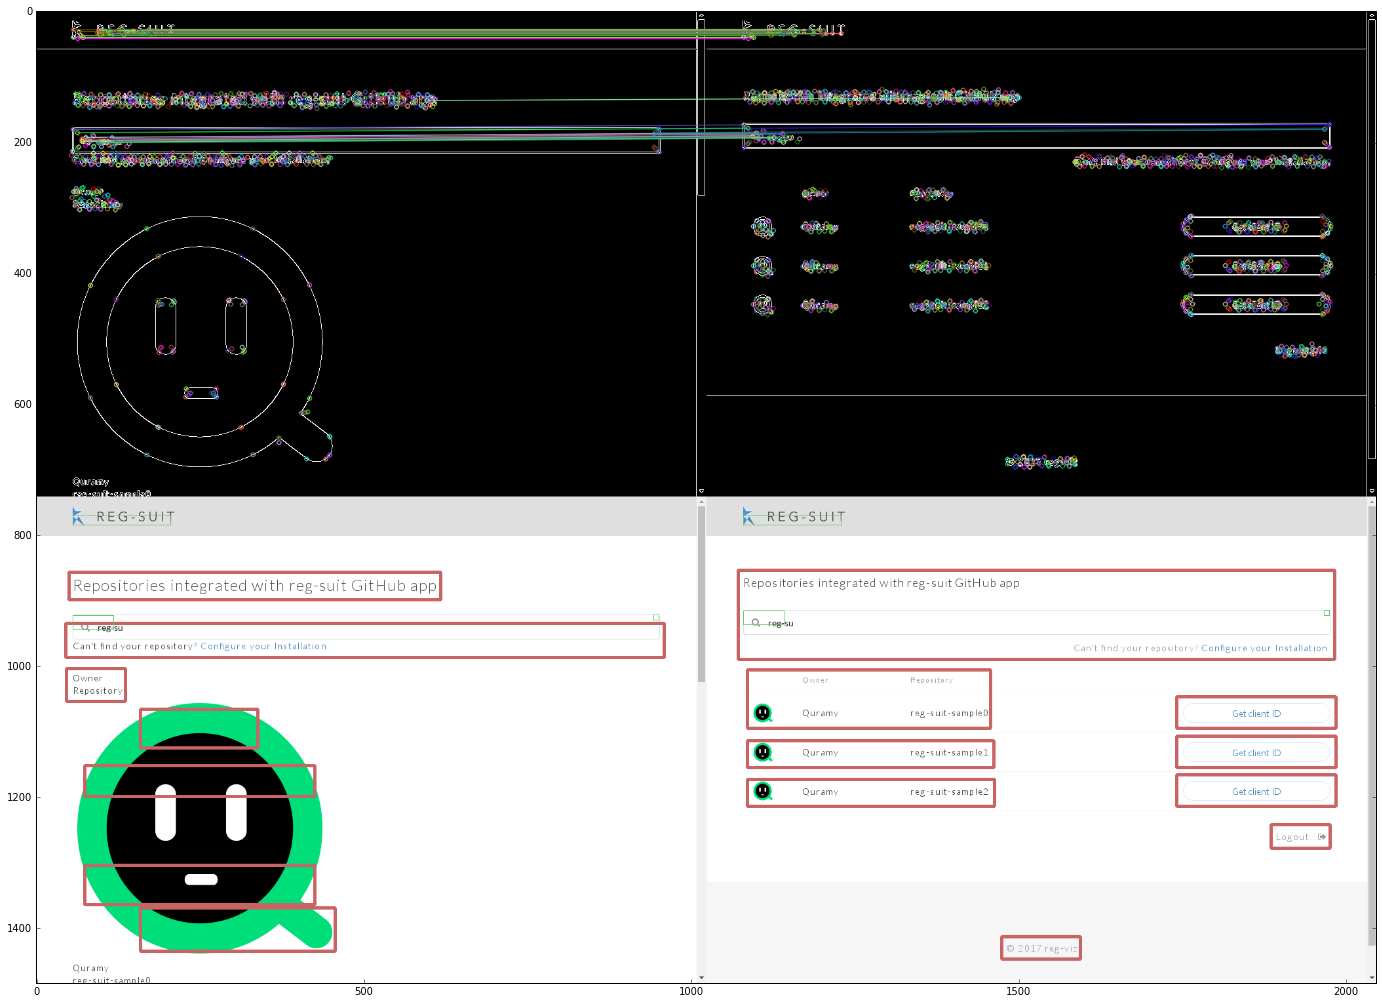

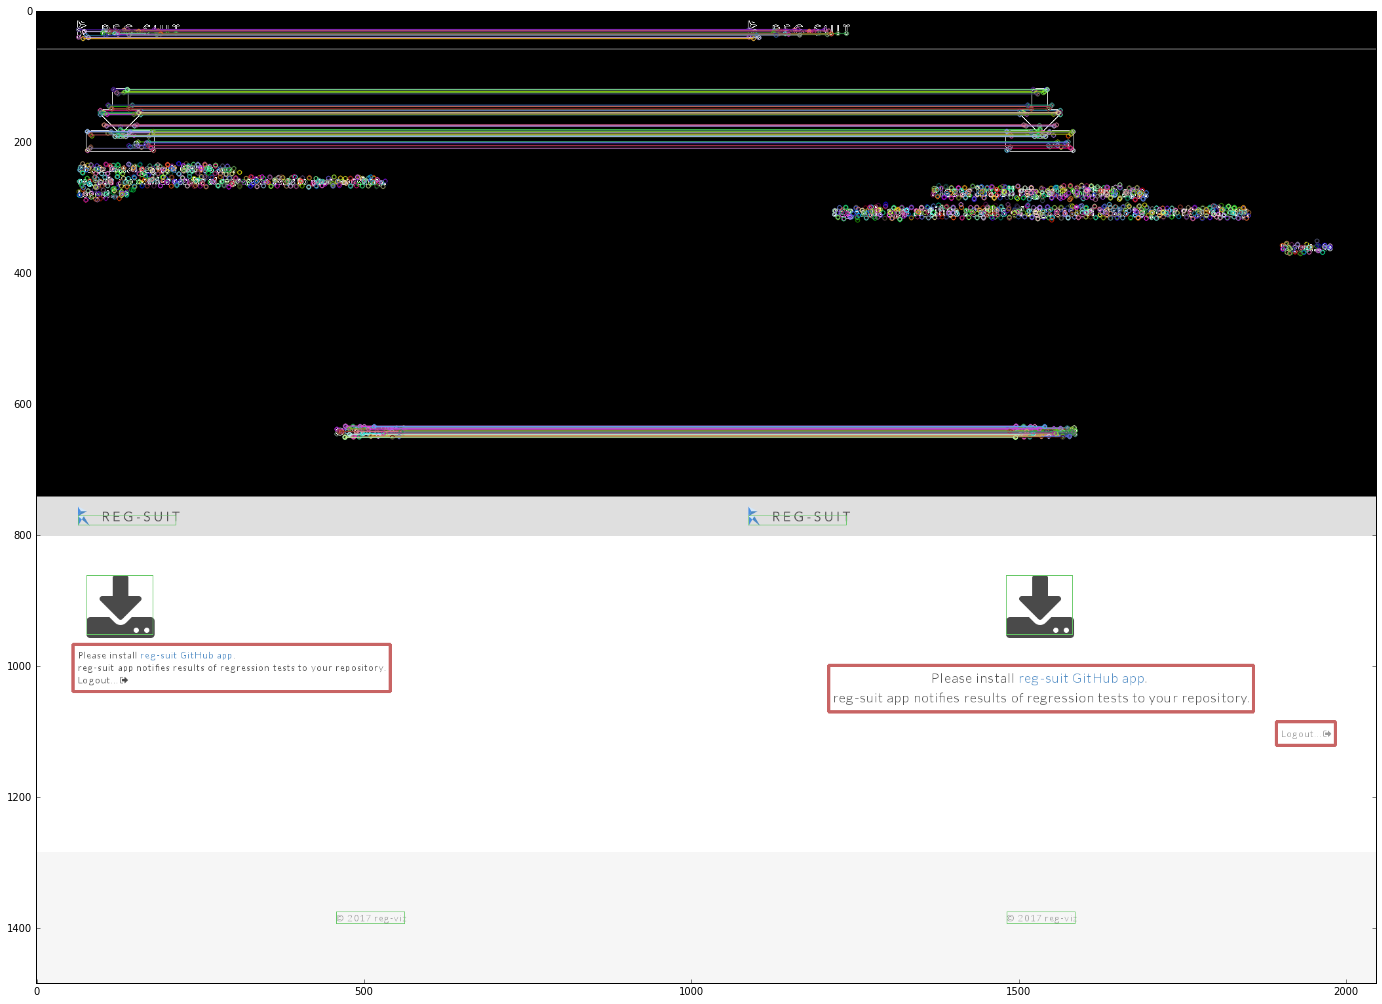

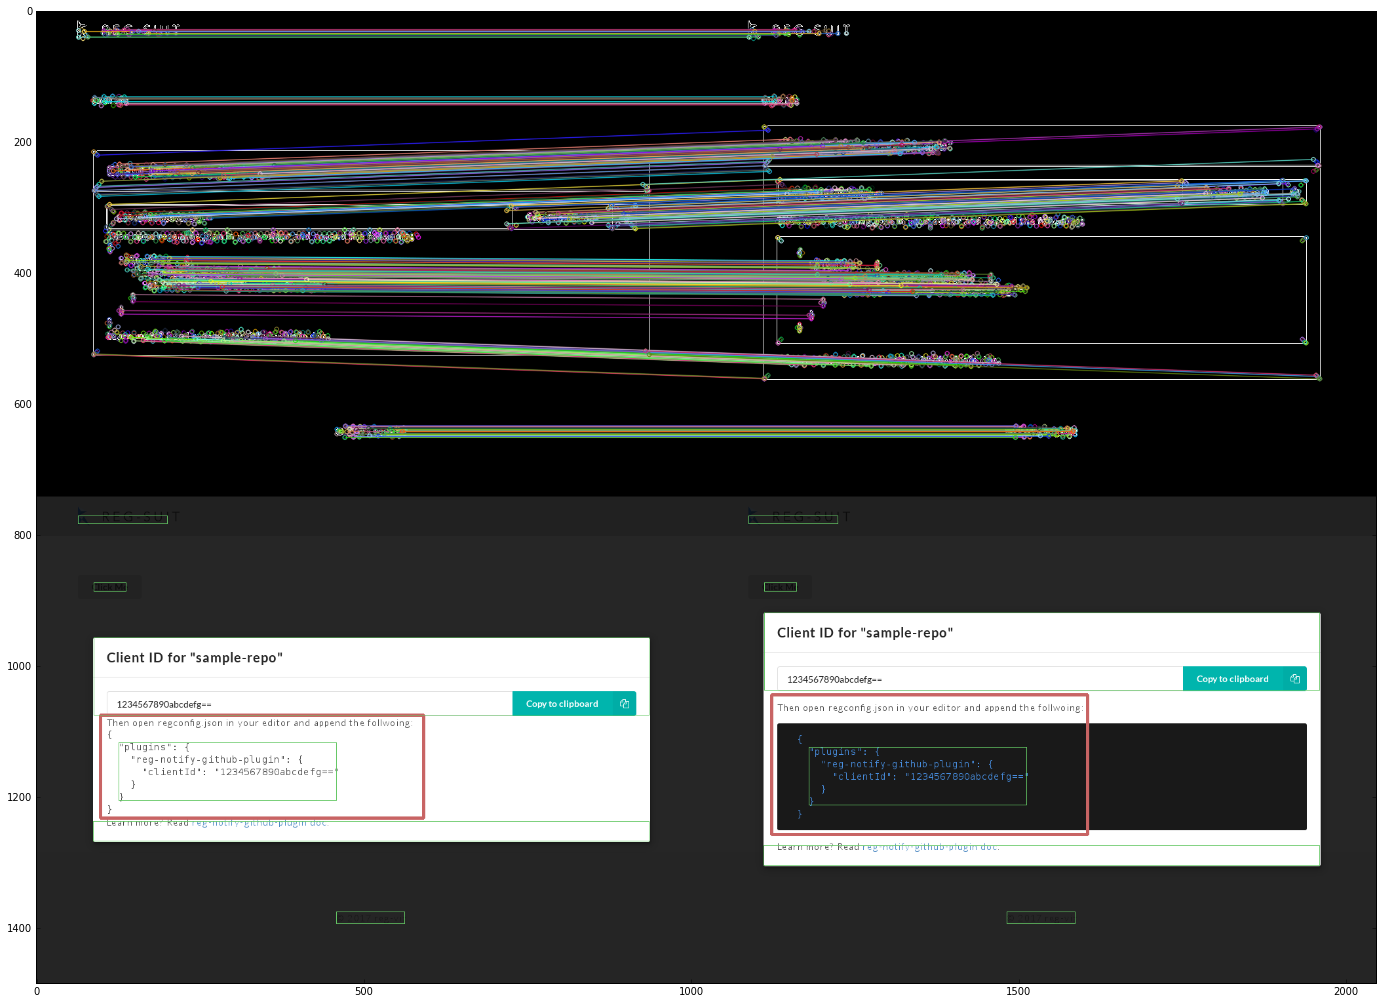

In [7]:
suffix_list = [
    'tweetdeck.png',
    'ut/cmp/should fetch similar sites.png',
    'ut/cmp/should debounce to fetch similar sites.png',
    'ut/cmp/should render similar site without invalid sites.png',
    'gh-app-front/app_installations.png',
    'gh-app-front/app_goto_install.png',
    'gh-app-front/client-id-modal.png'
]

for suffix in suffix_list:
    detect_diff(suffix)